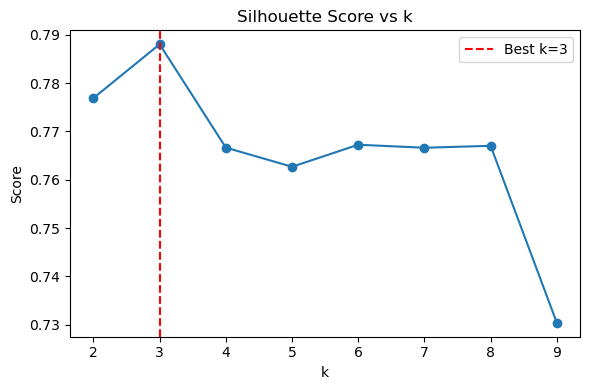

Cluster centroids (mean feature values):
                   viewCount     likeCount  commentCount  durationSeconds  \
cluster_label                                                               
0               30161.436671    693.733534     42.505549       766.913993   
1              112683.623188   2784.695652    125.982609      9965.115942   
2              648753.507937  19876.963492   1018.642857      1776.804762   

               channelSubscriberCount  
cluster_label                          
0                        4.469968e+05  
1                        1.253825e+07  
2                        1.840644e+06  
Dropped 5 rows from train due to inf/nan
Dropped 0 rows from test due to inf/nan
Shapes: (1477, 14) (371, 14)
Numeric max:
 durationSeconds           7.628100e+04
likeCount                 7.920500e+04
commentCount              1.011100e+04
channelSubscriberCount    4.280000e+07
publishHour               0.000000e+00
days_since_first          3.460000e+02
dur_x_subs     

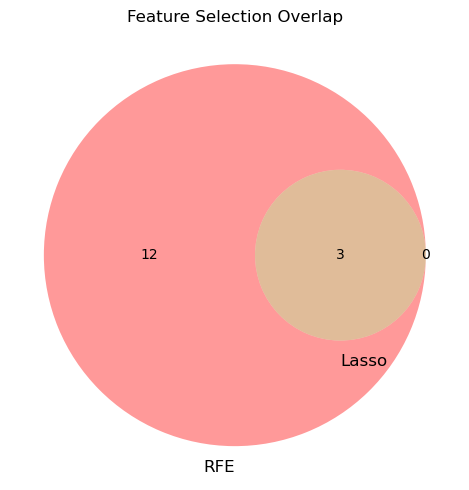

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2576
[LightGBM] [Info] Number of data points in the train set: 1477, number of used features: 21
[LightGBM] [Info] Start training from score 9.321343
Raw-space comparison:
                 MAE          RMSE        R2
Model                                      
XGB    31970.367188  94336.273438  0.732301
LGBM   31001.687508  96757.599946  0.718382
CAT    27830.618879  90337.662042  0.754513 



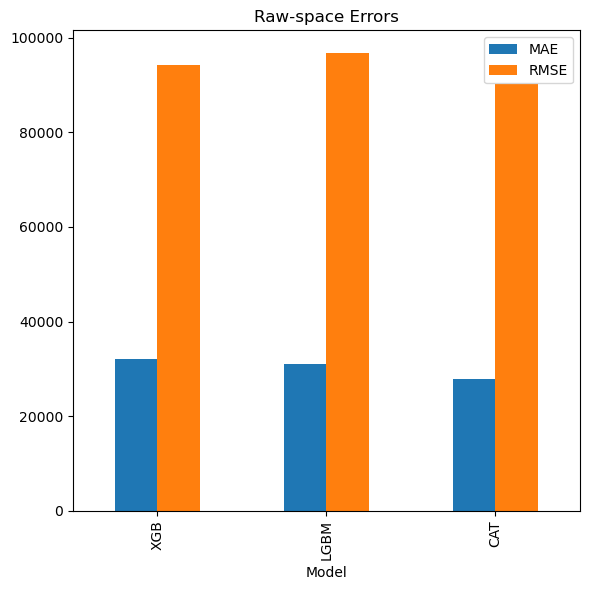

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 days 20 hours 39 mins
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_NJ_e2jaf3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.924 Gb
H2O_cluster_total_cores:,24
H2O_cluster_allowed_cores:,24
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
11:44:51.910: AutoML: XGBoost is not available; skipping it.
11:44:51.923: _train param, Dropping bad and constant columns: [publishHour]
11:44:52.25: _train param, Dropping bad and constant columns: [publishHour]
11:44:52.797: _train param, Dropping bad and constant columns: [publishHour]
11:44:54.504: _train param, Dropping bad and constant columns: [publishHour]
11:44:55.252: _train param, Dropping bad and constant columns: [publishHour]
11:44:56.82: _train param, Dropping bad and constant columns: [publishHour]

██
11:44:56.813: _train param, Dropping bad and constant columns: [publishHour]
11:44:58.514: _train param, Dropping bad and constant columns: [publishHour]
11:44:59.44: _train param, Dropping bad and constant columns: [publishHour]
11:44:59.902: _train param, Dropping unused columns: [publishHour]
11:45:00.182: _train param, Dropping unused columns: [publishHo

11:46:14 - cmdstanpy - INFO - Chain [1] start processing


H2O AutoML (log‑space): MAE=0.498, RMSE=0.720, R²=0.850
H2O AutoML (raw‑space): MAE=29480, RMSE=93381, R²=0.738


11:46:14 - cmdstanpy - INFO - Chain [1] done processing


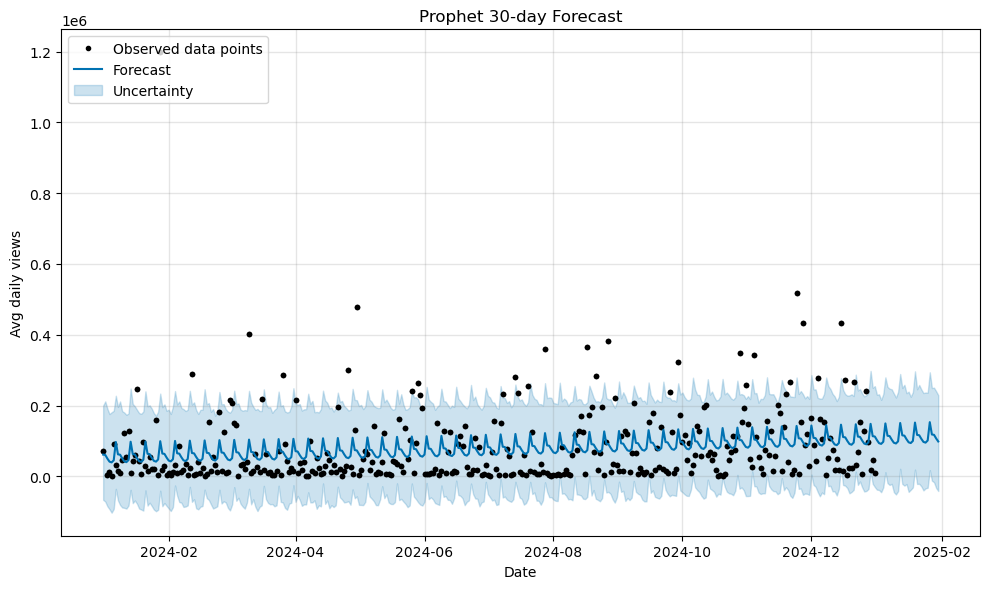

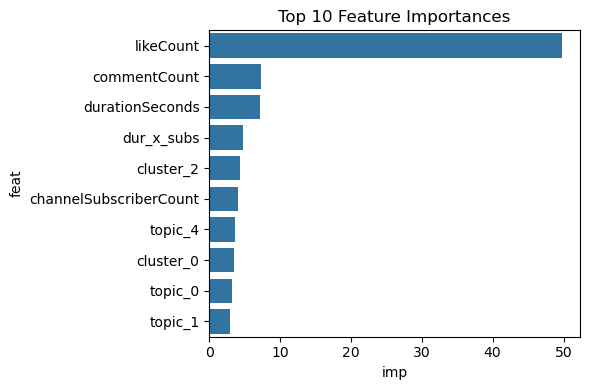

streamlit_app.py generated — run with `streamlit run streamlit_app.py`
Average actual views = 72,205
Hold‑out  MAE         = 13,287
Hold‑out  RMSE        = 42,758
Hold‑out  R²          = 0.945


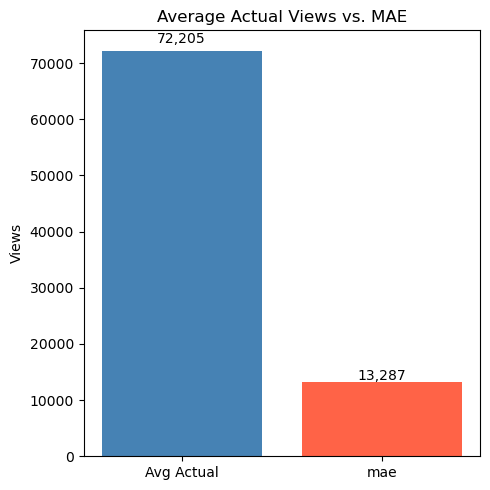

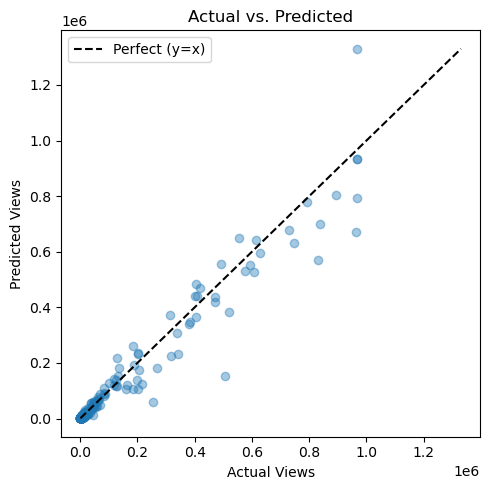

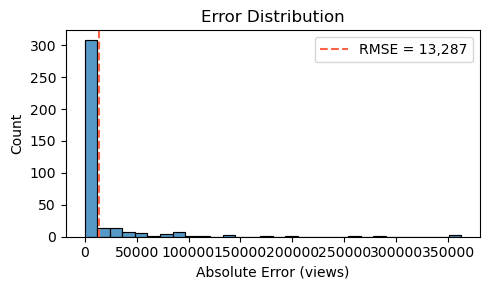

Wrote predictions_vs_actuals.csv


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error
)
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from matplotlib_venn import venn2
from prophet import Prophet
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split

# =============================================================================
# 1. Load, Clean & Outlier Removal
# =============================================================================
def load_data(path):
    df = pd.read_excel(path)
    df['publishDate'] = pd.to_datetime(df['publishDate'], errors='coerce')
    df['title']       = df['title'].fillna('').astype(str)
    df['description'] = df['description'].fillna('').astype(str)

    # Impute numeric
    num_cols = ['viewCount','likeCount','commentCount','durationSeconds','channelSubscriberCount']
    df[num_cols] = KNNImputer(n_neighbors=5).fit_transform(df[num_cols])

    # Remove extreme log‑view outliers
    df['log_views'] = np.log1p(df['viewCount'])
    zs = (df['log_views'] - df['log_views'].mean()) / df['log_views'].std()
    df = df[np.abs(zs) <= 2].reset_index(drop=True)
    df.drop(columns='log_views', inplace=True)
    return df

df = load_data("cleaned_data.xlsx")

# =============================================================================
# 2. Feature Engineering
# =============================================================================
def cluster_and_plot(df):
    perf = ['viewCount','likeCount','commentCount','durationSeconds','channelSubscriberCount']
    scaler = StandardScaler().fit(df[perf])
    Xp = scaler.transform(df[perf])

    ks = list(range(2,10))
    scores = [silhouette_score(Xp, KMeans(n_clusters=k, random_state=42)
                                       .fit_predict(Xp)) for k in ks]
    best_k = ks[np.argmax(scores)]
    kmeans = KMeans(n_clusters=best_k, random_state=42).fit(Xp)
    df['cluster'] = kmeans.labels_.astype(str)

    plt.figure(figsize=(6,4))
    plt.plot(ks, scores, 'o-')
    plt.axvline(best_k, color='r', ls='--', label=f'Best k={best_k}')
    plt.title('Silhouette Score vs k'); plt.xlabel('k'); plt.ylabel('Score')
    plt.legend(); plt.tight_layout(); plt.show()

    centroids = scaler.inverse_transform(kmeans.cluster_centers_)
    centers_df = pd.DataFrame(centroids, columns=perf)
    centers_df.index.name = 'cluster_label'
    print("Cluster centroids (mean feature values):")
    print(centers_df)

    label_map = {
        '0': "Small Reach & Mid‑Size Channels",
        '1': "Long Videos on Mega Channels",
        '2': "High Engagement Mid‑Length Videos"
    }
    df['cluster_desc'] = df['cluster'].map(label_map)
    return centers_df

centroids = cluster_and_plot(df)

# Cap viewCount at 99th percentile
cap = df['viewCount'].quantile(0.99)
df['viewCount_capped'] = df['viewCount'].clip(upper=cap)

# Text → LDA topics
raw_text = (df['title'] + ' ' + df['description']).str.lower() \
           .str.replace('artificial intelligence','artificialintelligence', regex=False)
stops = list(ENGLISH_STOP_WORDS.union({'http','https','www','com','youtu','youtube'}))
vec = CountVectorizer(
    stop_words=stops,
    token_pattern=r'(?u)\b[^\W\d_]{3,}\b',
    max_features=500, min_df=5, max_df=0.5
)
dtm = vec.fit_transform(raw_text)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
probs = lda.fit_transform(dtm)
for i in range(5):
    df[f'topic_{i}'] = probs[:,i]
df['dominant_topic'] = probs.argmax(axis=1)
pickle.dump(vec, open('vectorizer.pkl','wb'))
pickle.dump(lda, open('lda_model.pkl','wb'))

# Temporal & interaction features
first = df.groupby('channelTitle')['publishDate'].transform('min')
df['publishHour']      = pd.to_datetime(df['publishTimeUTC'], errors='coerce')\
                             .dt.hour.fillna(0).astype(int)
df['publishDayOfWeek'] = df['publishDate'].dt.day_name()
df['days_since_first'] = (df['publishDate'] - first).dt.days

# Log‑transform dur_x_subs to keep it bounded
df['dur_x_subs'] = np.log1p(df['durationSeconds'] * df['channelSubscriberCount'])

# =============================================================================
# 3. Prepare for Modeling
# =============================================================================
num_feats = [
    'durationSeconds','likeCount','commentCount','channelSubscriberCount',
    'publishHour','days_since_first','dur_x_subs'
] + [f'topic_{i}' for i in range(5)]
cat_feats = ['cluster','publishDayOfWeek']

X = df[num_feats + cat_feats]
y = np.log1p(df['viewCount_capped'])

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Drop non‑finite
mask_tr = np.all(np.isfinite(Xtr[num_feats]), axis=1) & np.isfinite(ytr)
print(f"Dropped {len(Xtr)-mask_tr.sum()} rows from train due to inf/nan")
Xtr, ytr = Xtr.loc[mask_tr], ytr.loc[mask_tr]

mask_te = np.all(np.isfinite(Xte[num_feats]), axis=1) & np.isfinite(yte)
print(f"Dropped {len(Xte)-mask_te.sum()} rows from test due to inf/nan")
Xte, yte = Xte.loc[mask_te], yte.loc[mask_te]

# Clip raw numeric features to ±1e8
for c in num_feats:
    Xtr[c] = Xtr[c].clip(-1e8, 1e8)
    Xte[c] = Xte[c].clip(-1e8, 1e8)

# Diagnostics
print("Shapes:", Xtr.shape, Xte.shape)
print("Numeric max:\n", Xtr[num_feats].abs().max())

# Cast numeric to float32
Xtr.loc[:, num_feats] = Xtr[num_feats].astype('float32')
Xte.loc[:, num_feats] = Xte[num_feats].astype('float32')
ytr = ytr.astype('float32')
yte = yte.astype('float32')

# =============================================================================
# 4. Preprocessor & Feature Selection
# =============================================================================
prep = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
])

rfe = RFE(XGBRegressor(random_state=42), n_features_to_select=15)
pipe_rfe = Pipeline([('pr', prep), ('rfe', rfe)])
pipe_rfe.fit(Xtr, ytr)
feat_names = num_feats + list(pipe_rfe.named_steps['pr']
                              .transformers_[1][1]
                              .get_feature_names_out())
rfe_sel = set(np.array(feat_names)[rfe.support_])

las = Pipeline([
    ('im', SimpleImputer(strategy='median')),
    ('sc', StandardScaler()),
    ('l', LassoCV(cv=10))
])
las.fit(Xtr[num_feats], ytr)
ls_sel = set(pd.Series(las.named_steps['l'].coef_, index=num_feats)
             [lambda s: s != 0].index)

plt.figure(figsize=(5,5))
venn2([rfe_sel, ls_sel], ('RFE','Lasso'))
plt.title('Feature Selection Overlap'); plt.tight_layout(); plt.show()

# =============================================================================
# 5–6. Model Candidates & Selection
# =============================================================================
def eval_mods(mods):
    results = []
    for name, m in mods.items():
        pipe = Pipeline([('pr', prep), ('m', m)])
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xte)
        results.append((
            name,
            mean_absolute_error(np.expm1(yte), np.expm1(pred)),
            root_mean_squared_error(np.expm1(yte), np.expm1(pred)),
            r2_score(np.expm1(yte), np.expm1(pred))
        ))
    return pd.DataFrame(results, columns=['Model','MAE','RMSE','R2']).set_index('Model')

def compare_with_manual_best(mods):
    raw = eval_mods(mods)
    print("Raw-space comparison:\n", raw, "\n")
    raw[['MAE','RMSE']].plot.bar(figsize=(6,6))
    plt.title('Raw-space Errors'); plt.tight_layout(); plt.show()
    best = raw['RMSE'].idxmin()
    return raw, {'model': best}

mods = {
    'XGB': XGBRegressor(random_state=42),
    'LGBM': LGBMRegressor(random_state=42),
    'CAT': CatBoostRegressor(verbose=0, random_state=42)
}

raw_results, log_results = compare_with_manual_best(mods)

# =============================================================================
# 7. H2O AutoML + R² evaluation
# =============================================================================
h2o.init(max_mem_size='4G')
hf = h2o.H2OFrame(pd.concat([Xtr, ytr.rename('log')], axis=1))
aml = H2OAutoML(max_models=10, seed=42, max_runtime_secs=300)
aml.train(x=Xtr.columns.tolist(), y='log', training_frame=hf)

preds_h2o = aml.leader.predict(h2o.H2OFrame(Xte)).as_data_frame()['predict']
mae_h2o_log  = mean_absolute_error(yte, preds_h2o)
rmse_h2o_log = root_mean_squared_error(yte, preds_h2o)
r2_h2o_log   = r2_score(yte, preds_h2o)

y_raw = np.expm1(yte)
p_raw = np.expm1(preds_h2o)
mae_h2o_raw  = mean_absolute_error(y_raw, p_raw)
rmse_h2o_raw = root_mean_squared_error(y_raw, p_raw)
r2_h2o_raw   = r2_score(y_raw, p_raw)

print(f"H2O AutoML (log‑space): MAE={mae_h2o_log:.3f}, RMSE={rmse_h2o_log:.3f}, R²={r2_h2o_log:.3f}")
print(f"H2O AutoML (raw‑space): MAE={mae_h2o_raw:.0f}, RMSE={rmse_h2o_raw:.0f}, R²={r2_h2o_raw:.3f}")

# =============================================================================
# 8. Prophet Forecast (unchanged)
# =============================================================================
daily = df.set_index('publishDate').resample('D')['viewCount'].mean().reset_index().rename(columns={'publishDate':'ds','viewCount':'y'})
m = Prophet(weekly_seasonality=True)
m.fit(daily)
fut = m.make_future_dataframe(periods=30)
fc  = m.predict(fut)

fig = m.plot(fc)
ax  = fig.gca()
ax.scatter(daily['ds'], daily['y'], color='k', marker='.')
ax.collections[0].set_label('Uncertainty')
ax.legend(loc='upper left')
plt.xlabel('Date'); plt.ylabel('Avg daily views')
plt.title('Prophet 30‑day Forecast'); plt.tight_layout(); plt.show()

# =============================================================================
# 9–11. Champion pipeline (dynamic) + Feature Importance
# =============================================================================
best_name   = log_results['model']
champ_model = mods.get(best_name)
if champ_model is None:
    raise KeyError(f"Winning model '{best_name}' not found in mods dict")

champ = Pipeline([
    ('pr', prep),
    ('m', champ_model)
])
champ.fit(X, y)
pickle.dump(champ, open('champion_pipeline.pkl', 'wb'))

imp = champ.named_steps['m'].feature_importances_
fn  = num_feats + list(champ.named_steps['pr']
        .transformers_[1][1]
        .get_feature_names_out())
fi  = pd.DataFrame({'feat':fn,'imp':imp}).sort_values('imp',ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(x='imp',y='feat',data=fi.head(10))
plt.title('Top 10 Feature Importances'); plt.tight_layout(); plt.show()


topic_perf = df.groupby('dominant_topic')['viewCount'].mean().to_dict()
slot_perf  = dict(df.groupby(['publishDayOfWeek','publishHour'])['viewCount'].mean().nlargest(5))

streamlit_template = '''

import streamlit as st
import pandas as pd
import numpy as np
import pickle

# Import model dependencies to ensure pickle unpacks correctly
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

pipeline = pickle.load(open('champion_pipeline.pkl', 'rb'))
vec = pickle.load(open('vectorizer.pkl', 'rb'))
lda = pickle.load(open('lda_model.pkl', 'rb'))

CLUSTER_LABELS = {
    '0': "Small Reach & Mid‑Size Channels",
    '1': "Long Videos on Mega Channels",
    '2': "High Engagement Mid‑Length Videos"
}
CLUSTER_OPTS = list(CLUSTER_LABELS.keys())
DOW_OPTS = ['Thursday', 'Monday', 'Tuesday',
            'Saturday', 'Wednesday', 'Friday', 'Sunday']
TOPIC_PERF = {0: 87767.30685920578, 1: 29872.04375,
              2: 46434.066666666666, 3: 71323.46124031008, 4: 83114.3584131327}
SLOT_PERF = {('Sunday', 0): 86140.45497630331, ('Tuesday', 0): 82976.74545454545, ('Monday', 0)             : 82853.79841897234, ('Wednesday', 0): 73940.75357142858, ('Saturday', 0): 72698.1551724138}

st.title("YouTube View Predictor & Recommendations")

# Inputs
publishHour = 0

duration = st.sidebar.number_input("Duration (s)", min_value=0)
likes = st.sidebar.number_input("Like Count", min_value=0)
comments = st.sidebar.number_input("Comment Count", min_value=0)
subs = st.sidebar.number_input("Channel Subscribers", min_value=0)
days = st.sidebar.number_input("Days Since First Video", min_value=0)
durxsub = duration * subs
cluster_choice = st.sidebar.selectbox(
    "Channel + Content Profile",
    [f"{code} – {label}" for code, label in CLUSTER_LABELS.items()]
)
cluster = cluster_choice.split(" – ")[0]
dow = st.sidebar.selectbox("Day Of Week", DOW_OPTS)

topic_probs = {f'topic_{i}': st.sidebar.slider(
    f'Topic {i} Prob', 0.0, 1.0, 0.0) for i in range(5)}


input_df = pd.DataFrame([{**{
    'durationSeconds': duration,
    'likeCount': likes,
    'commentCount': comments,
    'channelSubscriberCount': subs,
    'days_since_first': days,
    'dur_x_subs': durxsub,
    'cluster': cluster,
    'publishDayOfWeek': dow,
    'publishHour': publishHour,
    **topic_probs
}}])

# st.subheader("Input Features")
# st.write(input_df)

st.subheader("Input Features")
# Hide publishHour column
st.write(input_df.drop(columns=['publishHour'], errors='ignore'))

pred_log = pipeline.predict(input_df)[0]
pred = int(np.expm1(pred_log))
st.subheader("Predicted View Count")
st.write(f"{pred:,}")

st.subheader("Top Content Themes")
for t, v in TOPIC_PERF.items():
    st.write(f"Topic {t}: avg views {int(v):,}")

st.subheader("Recommended Publish Days")
for key, views in SLOT_PERF.items():
    # key may be a tuple (day, hour); extract only the day
    day = key[0] if isinstance(key, (tuple, list)) else key
    st.write(f"{day} → avg views {int(views):,}")


st.subheader("Topic Definitions")
feature_names = vec.get_feature_names_out()
n = 10
for idx, comp in enumerate(lda.components_):
    top_idxs = comp.argsort()[:-n-1:-1]
    terms = [feature_names[i] for i in top_idxs]
    st.write(f"Topic {idx}: {', '.join(terms)}")
'''
with open('streamlit_app.py','w') as f:
    f.write(streamlit_template)
print("streamlit_app.py generated — run with `streamlit run streamlit_app.py`")
# =============================================================================
# 12. Dump predictions vs actuals for the final champion
# =============================================================================
pred_log = champ.predict(Xte)
actuals  = np.expm1(yte)
preds    = np.expm1(pred_log)
diffs    = abs(preds - actuals)

rmse     = root_mean_squared_error(actuals, preds)
mae      = mean_absolute_error(actuals, preds)
r2       = r2_score(actuals, preds)
avg_views = actuals.mean()

print(f"Average actual views = {avg_views:,.0f}")
print(f"Hold‑out  MAE         = {mae:,.0f}")
print(f"Hold‑out  RMSE        = {rmse:,.0f}")
print(f"Hold‑out  R²          = {r2:.3f}")


plt.figure(figsize=(5,5))
plt.bar(['Avg Actual','mae'], [avg_views, mae], color=['steelblue','tomato'])
plt.ylabel('Views')
for i, v in enumerate([avg_views, mae]):
    plt.text(i, v*1.02, f"{v:,.0f}", ha='center')
plt.title('Average Actual Views vs. MAE')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(actuals, preds, alpha=0.4)
lims = [
    min(actuals.min(), preds.min()),
    max(actuals.max(), preds.max())
]
plt.plot(lims, lims, 'k--', label='Perfect (y=x)')
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('Actual vs. Predicted')
plt.legend()
plt.tight_layout()
plt.show()

errors = np.abs(preds - actuals)
plt.figure(figsize=(5,3))
sns.histplot(errors, bins=30, kde=False)
plt.axvline(mae, color='tomato', linestyle='--', label=f'RMSE = {mae:,.0f}')
plt.xlabel('Absolute Error (views)')
plt.title('Error Distribution')
plt.legend()
plt.tight_layout()
plt.show()


out = pd.DataFrame({
    'actual_views':    actuals,
    'predicted_views': preds,
    'error':           diffs,
    'rmse':            rmse,
    'mae':             mae,
    'r2':              r2  
})
out.to_csv('predictions_vs_actuals.csv', index=False)
print("Wrote predictions_vs_actuals.csv")
